In [ ]:
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import glob, os, time
import matplotlib.ticker as mticker
import heapq
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

In [11]:
def steiner_metric(G_m, V0):
    return nx.minimum_spanning_tree(G_m.subgraph(list(V0)))

def metric_closure(G, V0):
    R = list(V0)
    K = nx.Graph()
    K.add_nodes_from(R) 
    P = {}
    for i, s in enumerate(R):
        d, path = nx.single_source_dijkstra(G, s)
        for t in R[i+1:]:
            K.add_edge(s, t, weight=d[t])
            P[s, t] = path[t]
            P[t, s] = path[t][::-1]
    return K, P

def steiner_common(G, V0):
    K, P = metric_closure(G, V0)
    Tt = steiner_metric(K, V0)
    H = nx.Graph()
    for u, v in Tt.edges():
        p = P[u, v]
        for a, b in zip(p, p[1:]): H.add_edge(a, b, weight=G[a][b].get("weight", 1))

    return nx.minimum_spanning_tree(H)

In [12]:
def read_stp(path):
    G = nx.Graph(); R = []; mode = None
    for line in open(path, "r", encoding="utf-8", errors="ignore"):
        s = line.strip()
        if not s or s.startswith("#"): 
            continue
        if s.startswith("SECTION Graph"): mode = "g"; continue
        if s.startswith("SECTION Terminals"): mode = "t"; continue
        if s.startswith("END"): mode = None; continue
        if mode == "g" and s.startswith("E "):
            _, u, v, w = s.split()
            G.add_edge(int(u), int(v), weight=float(w))
        if mode == "t" and s.startswith("T "):
            _, v = s.split()
            R.append(int(v))
    return G, R

def wsum(T):
    return sum(d.get("weight", 1) for _, _, d in T.edges(data=True))

In [13]:
def steiner_opt(G, V0):
    R = list(V0); k = len(R)
    nodes = list(G.nodes); idx = {v:i for i,v in enumerate(nodes)}
    n = len(nodes); INF = float("inf")
    dp = [np.full(n, INF) for _ in range(1<<k)]

    for i, t in enumerate(R):
        dist = nx.single_source_dijkstra_path_length(G, t)
        a = dp[1<<i]
        for v, d in dist.items(): a[idx[v]] = d

    for mask in range(1, 1<<k):
        if mask & (mask-1):
            sub = (mask-1) & mask
            while sub:
                other = mask ^ sub
                if sub < other: dp[mask] = np.minimum(dp[mask], dp[sub] + dp[other])
                sub = (sub-1) & mask

            dist = dp[mask]
            h = [(dist[i], nodes[i]) for i in range(n) if dist[i] < INF]
            heapq.heapify(h)
            while h:
                d, u = heapq.heappop(h)
                iu = idx[u]
                if d != dist[iu]: continue
                for v, ed in G[u].items():
                    nd = d + ed.get("weight", 1)
                    iv = idx[v]
                    if nd < dist[iv]:
                        dist[iv] = nd
                        heapq.heappush(h, (nd, v))

    return float(dp[(1<<k)-1].min())

In [14]:
def _job(f, kmax, opt_limit_s):
    G, R = read_stp(f)

    t0 = time.perf_counter()
    T = steiner_common(G, R)
    t_alg = time.perf_counter() - t0
    alg = wsum(T)

    opt = ratio = t_opt = None
    if len(R) <= kmax:
        t1 = time.perf_counter()
        opt = steiner_opt(G, R)
        t_opt = time.perf_counter() - t1
        ratio = alg / opt
        if t_opt > opt_limit_s: opt = ratio = None

    return dict(
        file=os.path.basename(f),
        n=G.number_of_nodes(),
        m=G.number_of_edges(),
        t=len(R),
        alg=alg,
        opt=opt,
        ratio=ratio,
        t_alg=t_alg,
        t_opt=t_opt
    )

def run_dir_df_fast(dir_path, kmax=16, opt_limit_s=2.0, workers=12):
    files = sorted(glob.glob(dir_path.rstrip("/") + "/**/*.stp", recursive=True))
    rows = []
    ctx = mp.get_context("fork")
    with ProcessPoolExecutor(max_workers=workers, mp_context=ctx) as ex:
        futs = [ex.submit(_job, f, kmax, opt_limit_s) for f in files]
        for fu in tqdm(as_completed(futs), total=len(futs), desc="SteinLib"):
            rows.append(fu.result())
    return pd.DataFrame(rows)

DIR = "/home/ivan/Desktop/compl/data/steinlib/I080"
df = run_dir_df_fast(DIR, kmax=16, opt_limit_s=2.0, workers=12)
df_small = df.dropna(subset=["ratio"]).copy()

SteinLib: 100%|██████████| 100/100 [03:58<00:00,  2.39s/it]


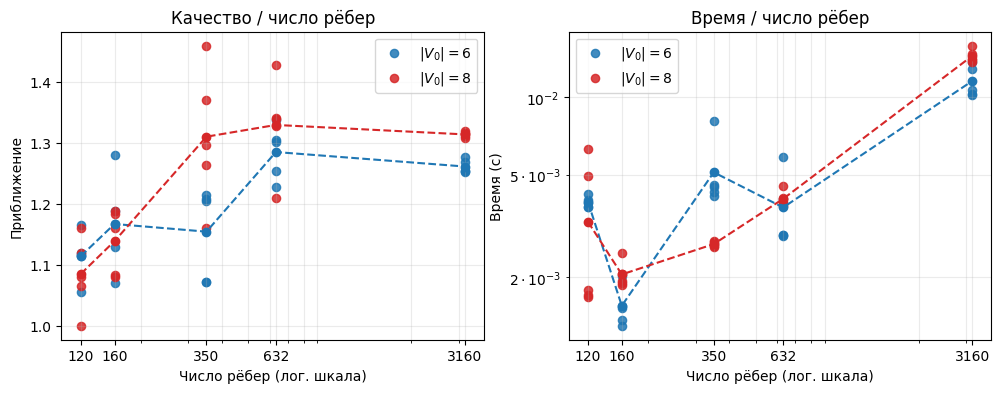

In [15]:
def plot_q_time_m_redblue(df, df_small):
    d1 = df_small[df_small["t"].isin([6, 8])]
    d2 = df[df["t"].isin([6, 8])]

    def sc(ax, data, title, ycol, ylog=False):
        for t, color in [(6, "tab:blue"), (8, "tab:red")]:
            part = data[data["t"] == t]
            ax.scatter(part["m"], part[ycol], s=35, alpha=0.85, label=r"$|V_0| = $" + str(t), color=color)

        ax.set_xscale("log")
        if ylog:
            ax.set_yscale("log")

            ax.yaxis.set_major_locator(mticker.LogLocator(base=10, numticks=10))
            ax.yaxis.set_major_formatter(mticker.LogFormatterMathtext(base=10))

            ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=(2, 5), numticks=100))

            def _fmt_minor(y, _):
                if y <= 0: 
                    return ""
                e = int(np.floor(np.log10(y)))
                m = y / (10**e)
                if abs(m-2) < 1e-8:
                    return rf"$2\cdot 10^{{{e}}}$"
                if abs(m-5) < 1e-8:
                    return rf"$5\cdot 10^{{{e}}}$"
                return ""

            ax.yaxis.set_minor_formatter(mticker.FuncFormatter(_fmt_minor))

        ms = np.sort(data["m"].unique())
        if len(ms) <= 6:
            xt = ms
        else:
            xt = np.unique(np.round(np.geomspace(ms.min(), ms.max(), 3))).astype(int)
        ax.set_xticks(xt)
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())

        ax.grid(True, which="both", alpha=0.25)

        ax.set_xlabel(r"Число рёбер (лог. шкала)")
        ax.set_ylabel("Приближение" if ycol == "ratio" else ("Время (с)"))
        ax.set_title(title)
        ax.legend()

        g = data.groupby(["m", "t"])[ycol].mean().reset_index()
        for t, color in [(6, "tab:blue"), (8, "tab:red")]:
            gt = g[g["t"] == t].sort_values("m")
            ax.plot(gt["m"], gt[ycol], linestyle="--", marker="o", color=color)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sc(ax[0], d1, "Качество / число рёбер", "ratio", ylog=False)
    sc(ax[1], d2, "Время / число рёбер", "t_alg", ylog=True)

    plt.savefig("fig_quality_time_m.pdf", bbox_inches="tight")
    plt.show()

plot_q_time_m_redblue(df, df_small)